# Imports

In [5]:
from helpers import *
import os
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns

from bs4 import BeautifulSoup # To Extract all the URLs from the HTML page

## NDLM'ADA - Look up ! Stars and how we them
#### *Timo Achard, Romane Clerc, Louise Font, Julie Korber, Emeric Martin*
Supplementary notebook containing additional data exploration and analysis not usefull for the main pipeline of our project. 

# Table of contents
* [Downloading the data](#section0)
* [Position of the links in each article pages](#section1)
    * [Extraction of the links position](#subsection_1_1)
    * [Distribution of the links by their position categories](#subsection_1_2)
    * [Linkage with the frequence of visit](#subsection_1_3)
* [](#section2)




# 0. Downloading the data <a classe="anchor" id="section0"></a>

In [6]:
dfs = preprocessing()

# 1. Position of the links in each article pages <a classe="anchor" id="section1"></a>

## 1.1 Extraction of the links position <a id="subsection_1_1"></a>

In [8]:
# List of paths to access the articles htm
list_articles_paths = []

# Iterate through all the htm files in all subfolders from the main folder wp 
for root, dirs, subfolders in os.walk('dataset/wpcd/wp/'):
    for file in subfolders:
        # Select only the htm files
        if file.endswith('.htm'):
            file_path = os.path.join(root, file)
            # Store htm usefull for the game 
            if '/index/' not in file_path:
                list_articles_paths.append(file_path)

len(list_articles_paths)

5237

In [9]:
def classify_href(links, length_page, source_name):
    """ It classifies each link from a provided list 
    parameters:
        links: list of bs4.element.Tag
        length_page: int, length of the article htm from which the links are from
        source_name: str, name of the article from which the links are from 
    return:
        dataFrame containing the name article with their link category and the number of occcurence in the list. 
     """
    categories = pd.DataFrame(columns=['source', 'target', 'category', 'line_position', 'relative_position'])

    # Specification of the categories
    block_level_elements = {'div',      # legend
                             'p',       # text
                            'table'}    # summary tables

    # Go through each link on the page
    for i, link in enumerate(links): 
        element = link

        # Get the line position
        line_position = link.sourceline 

        # Iterate until it find an element from the specified list (block_level_elements)
        while element and element.name not in block_level_elements:
            element = element.find_parent()

        # Rename the categories
        el_name = element.name
        if el_name == 'div':
            el_name = 'legend'
        elif el_name == 'p':
            el_name = 'text'

        # Store a new row with the corresponding info 
        categories.loc[i] = (source_name, path_to_name(link.get('href')), el_name, line_position, np.round(line_position/length_page,3))

    # Groupe the links with multiple occurrences, adjust their category if they belong to more than one, and sum their occurrences.
    categories = categories.groupby(['source', 'target'])[['category', 'line_position', 'relative_position']].agg(list).reset_index()
    categories['count'] = [len(l) for l in categories['category']] 
    categories['group'] = ['|'.join(sorted(np.unique(l))) for l in categories['category']] 
    categories = categories.sort_values(by = 'target')

    return categories


In [10]:
category_repartition = []
articles_df = pd.DataFrame(columns=['source', 'target', 'category', 'line_position', 'relative_position'])

#Iterate in each paths from the list of articles
for path in list_articles_paths:
    with open(path, 'r', encoding='utf-8', errors='replace') as file:
        soup = BeautifulSoup(file, 'html.parser')

    # Selection of the links
    all_links = soup.find_all('a', href=True)
    all_links = [link for link in all_links if '/images/' not in link.get('href') and 
                                                    'disclaimer.htm' not in link.get('href') and 
                                                    '/index/' not in link.get('href')and 
                                                    '.htm' in link.get('href')]
                                                    
    # Classification of the links
    class_ = classify_href(all_links, len(soup.find_all()), path_to_name(path))
    articles_df = pd.concat([articles_df, class_], axis = 0)

    category_repartition.append(class_.groupby(['group']).sum('count').rename(columns={'count': path_to_name(path)}))

# Calculation of the number of element in each categorise and their corresponding percentage 
category_repartition_df = pd.concat(category_repartition.copy(), axis = 1)
category_repartition_df.fillna(0, inplace = True)

repartition_summary = pd.DataFrame(columns = ['sum', 'percentage'])
repartition_summary['sum'] = category_repartition_df.sum(axis = 1).astype(int)
repartition_summary['percentage'] = np.round(repartition_summary['sum'].div(repartition_summary['sum'].sum()) * 100, 2)
    

In [11]:
print('Categories repartition')
display(repartition_summary)
print('\nPercentage of link being in multiple categories: {:.2f}%'.format(repartition_summary.loc[repartition_summary.index.str.contains('\|'),'percentage'].sum()))

Categories repartition


,sum,percentage
group,,
legend,21143,11.00
table,14033,7.30
table|text,19061,9.92
text,128974,67.09
legend|text,6485,3.37
legend|table|text,2312,1.20
legend|table,227,0.12



Percentage of link being in multiple categories: 14.61%


## 1.2 Distribution of the links by their position categories <a id="subsection_1_2"></a>

In [12]:
a = articles_df.copy()[['group', 'category']].explode('category')
dummies = pd.get_dummies(a['category']).astype(int)
a = pd.concat([a, dummies], axis=1).drop('category', axis = 1)
a = a.groupby('group', as_index=False).sum()
fig = px.bar(a, x='group', y=a.columns.values)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

In [13]:
a = articles_df.copy()[['group', 'category']].explode('category')
dummies = pd.get_dummies(a['group']).astype(int)
a = pd.concat([a, dummies], axis=1).drop('group', axis = 1)
a = a.groupby('category', as_index=False).sum()
fig = px.bar(a, x='category', y=a.columns.values, title="Position repartition")
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

## 1.3 Linkage with the frequence of visit <a id="subsection_1_3"></a>

In [14]:
paths =  pd.concat([dfs['paths_unfinished'].path, dfs['paths_finished'].path], axis=0)
paths = paths.str.split(';')
paths = paths[paths.apply(lambda x: len(x) != 1)].reset_index(drop=True)
paths_df = pd.concat([paths, paths], axis = 1)
paths_df.columns = ['original', 'modified']
paths_df.modified = [replace_return(list_) for list_ in paths_df.modified]

In [15]:
# Separating the original lists as new list of list of 2 articles (source, target)
link_table_user = [list_[i:i+2] for list_ in paths_df.modified for i in range(len(list_)-1)]
link_table_user = pd.DataFrame(link_table_user, columns=['source', 'target'])
link_table_user.sort_values(by = 'source', inplace = True)

# Remove the row with target starting with a point --> remove the return which are not a user link selection
link_table_user = link_table_user[~link_table_user['target'].str.startswith('.')]

# We don't need to know the past of the source article --> remove the return indication
link_table_user['source'] = link_table_user['source'].str.lstrip('.')

# Count how many times the link between the source and the direct target articles are selected
link_table_user = link_table_user.groupby(['source', 'target']).size().reset_index(name='count_link_selection')

display(link_table_user)

,source,target,count_link_selection
0,10th_century,11th_century,21
1,10th_century,9th_century,33
2,10th_century,Algeria,2
3,10th_century,Beer,2
4,10th_century,Byzantine_Empire,5
...,...,...,...
58955,Édouard_Manet,Renaissance,1
58956,Éire,Canada,1
58957,Éire,Ireland,3
58958,Éire,Republic_of_Ireland,1


In [16]:
print('The more used path was selected {} times.'.format(max(link_table_user.count_link_selection)))
link_table_user[link_table_user.count_link_selection >= 500]

The more used path was selected 709 times.


,source,target,count_link_selection
3822,Animal,Mammal,705
8944,Brain,Computer_science,709
13603,Communication,Telephone,539
19254,Europe,United_Kingdom,634
38530,North_America,United_States,677
54803,United_Kingdom,England,511
55220,United_States,President_of_the_United_States,553


In [17]:
# Add the link selection to the article_df dataframe
articles_df = articles_df.merge(link_table_user, on = ['source', 'target'], how= 'outer')
articles_df.fillna(0, inplace = True)
display(articles_df)

,source,target,category,line_position,relative_position,count,group,count_link_selection
0,Royal_Marines,15th_Marine_Expeditionary_Unit,[text],[308],[0.521],1.0,text,1.0
1,Royal_Marines,Afghanistan,"[text, text, text]","[308, 308, 308]","[0.521, 0.521, 0.521]",3.0,text,0.0
2,Royal_Marines,American_Revolutionary_War,[text],[293],[0.496],1.0,text,0.0
3,Royal_Marines,Antwerp,"[text, text]","[296, 302]","[0.501, 0.511]",2.0,text,0.0
4,Royal_Marines,Argentina,[text],[308],[0.521],1.0,text,3.0
...,...,...,...,...,...,...,...,...
141925,World_War_II,Warsaw,[text],[150],[0.108],1.0,text,5.0
141926,World_War_II,Wikipedia_Text_of_the_GNU_Free_Documentation_L...,[legend],[650],[0.469],1.0,legend,0.0
141927,World_War_II,Winston_Churchill,"[table, text, text, text, text]","[90, 242, 270, 409, 505]","[0.065, 0.175, 0.195, 0.295, 0.364]",5.0,table|text,41.0
141928,World_War_II,Yugoslavia,[text],[224],[0.162],1.0,text,10.0


In [18]:
# For the source-target link that appear more than once, compute their position mean (for the statistical test)
articles_df['relative_position_mean'] = [np.mean(pos) for pos in articles_df.relative_position]
articles_df

,source,target,category,line_position,relative_position,count,group,count_link_selection,relative_position_mean
0,Royal_Marines,15th_Marine_Expeditionary_Unit,[text],[308],[0.521],1.0,text,1.0,0.5210
1,Royal_Marines,Afghanistan,"[text, text, text]","[308, 308, 308]","[0.521, 0.521, 0.521]",3.0,text,0.0,0.5210
2,Royal_Marines,American_Revolutionary_War,[text],[293],[0.496],1.0,text,0.0,0.4960
3,Royal_Marines,Antwerp,"[text, text]","[296, 302]","[0.501, 0.511]",2.0,text,0.0,0.5060
4,Royal_Marines,Argentina,[text],[308],[0.521],1.0,text,3.0,0.5210
...,...,...,...,...,...,...,...,...,...
141925,World_War_II,Warsaw,[text],[150],[0.108],1.0,text,5.0,0.1080
141926,World_War_II,Wikipedia_Text_of_the_GNU_Free_Documentation_L...,[legend],[650],[0.469],1.0,legend,0.0,0.4690
141927,World_War_II,Winston_Churchill,"[table, text, text, text, text]","[90, 242, 270, 409, 505]","[0.065, 0.175, 0.195, 0.295, 0.364]",5.0,table|text,41.0,0.2188
141928,World_War_II,Yugoslavia,[text],[224],[0.162],1.0,text,10.0,0.1620


In [19]:
unique_group = articles_df.copy()[articles_df.group.isin(['text', 'table', 'legend'])]
len(unique_group)/len(articles_df)

0.9390192348340731

<Axes: xlabel='group', ylabel='relative_position_mean'>

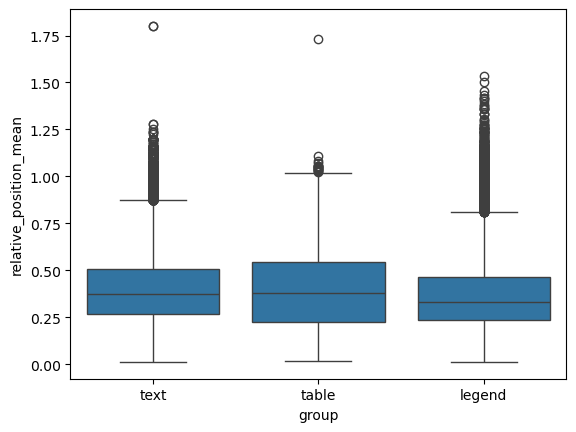

In [20]:
# Boxplot of relative_position_mean ditribution according to the unique category 
sns.boxplot(x='group', y='relative_position_mean', data=unique_group)


# 2. NEW SUBJECT <a id="section_2"></a>